# **Predicting Hazardous NEOs (Nearest Earth Objects)**

In [51]:
# libararies needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ivansher/nasa-nearest-earth-objects-1910-2024")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ivansher/nasa-nearest-earth-objects-1910-2024/versions/2


In [25]:
data = pd.read_csv(path+'/nearest-earth-objects(1910-2024).csv')
print('data info :')
print(data.info())
print()

print('frist 10 rows of data :')
print(data.head(10))
print()

data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB
None

frist 10 rows of data :
    neo_id                name  absolute_magnitude  estimated_diameter_min  \
0  2162117  162117 (1998 SD15)               19.14                0.394962   
1  2349507    349507 (2008

# Data cleaning

In [26]:
# check duplicated
data.duplicated().sum()

0

In [27]:
# check null values
data.isna().sum()

,0
neo_id,0
name,0
absolute_magnitude,28
estimated_diameter_min,28
estimated_diameter_max,28
orbiting_body,0
relative_velocity,0
miss_distance,0
is_hazardous,0


In [28]:
# Handle missing values by filling with the mean for numerical columns
data['absolute_magnitude'].fillna(data['absolute_magnitude'].mean(), inplace=True)
data['estimated_diameter_min'].fillna(data['estimated_diameter_min'].mean(), inplace=True)
data['estimated_diameter_max'].fillna(data['estimated_diameter_max'].mean(), inplace=True)
clear_output()

In [29]:
#check
data.isna().sum()

,0
neo_id,0
name,0
absolute_magnitude,0
estimated_diameter_min,0
estimated_diameter_max,0
orbiting_body,0
relative_velocity,0
miss_distance,0
is_hazardous,0


In [30]:
#check balanced data
data['is_hazardous'].value_counts()

,count
is_hazardous,
False,295037
True,43162


data is not balanced

In [10]:
from sklearn.utils import resample
# make data balanced
# Separate classes
df_hazardous = data[data["is_hazardous"] == True]
df_non_hazardous = data[data["is_hazardous"] == False]

# Undersample majority class
df_non_hazardous_sample = resample(df_non_hazardous,
                                   replace=False,   # Without replacement
                                   n_samples=len(df_hazardous),  # Match hazardous count
                                   random_state=42)

# Combine both
df_balanced = pd.concat([df_hazardous, df_non_hazardous_sample])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced["is_hazardous"].value_counts())

is_hazardous
False    43162
True     43162
Name: count, dtype: int64


In [31]:
# convert categorical feature
encoder = LabelEncoder()
df_balanced["orbiting_body"] = encoder.fit_transform(df_balanced['orbiting_body'])

In [33]:
# spliting the data
X = df_balanced.drop(['neo_id', 'name','is_hazardous'], axis=1)
y = df_balanced['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# EDA

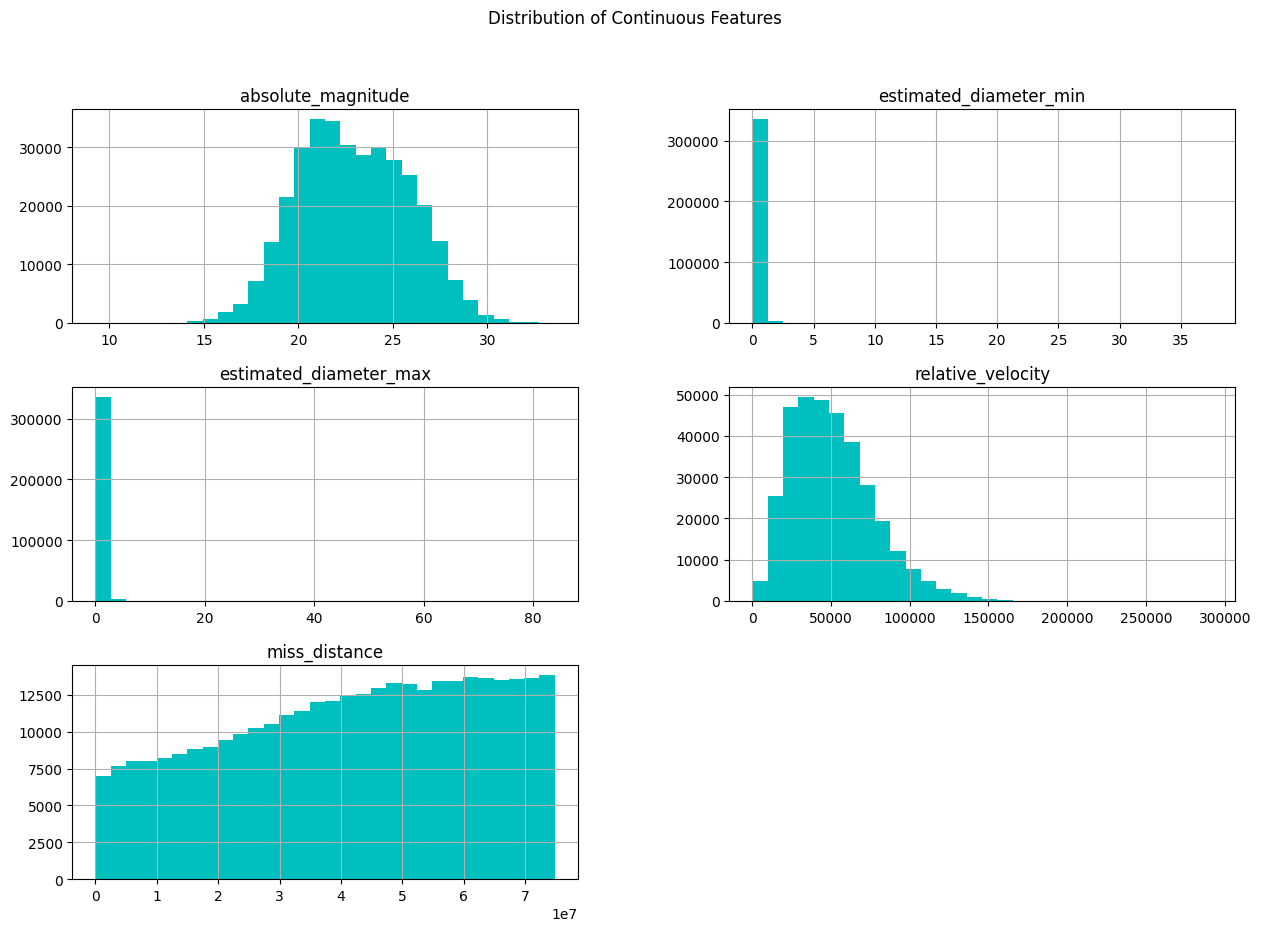

In [13]:

num_cols = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max", "relative_velocity", "miss_distance"]
data[num_cols].hist(bins=30, figsize=(15, 10), color='c')
plt.suptitle("Distribution of Continuous Features")
plt.show()


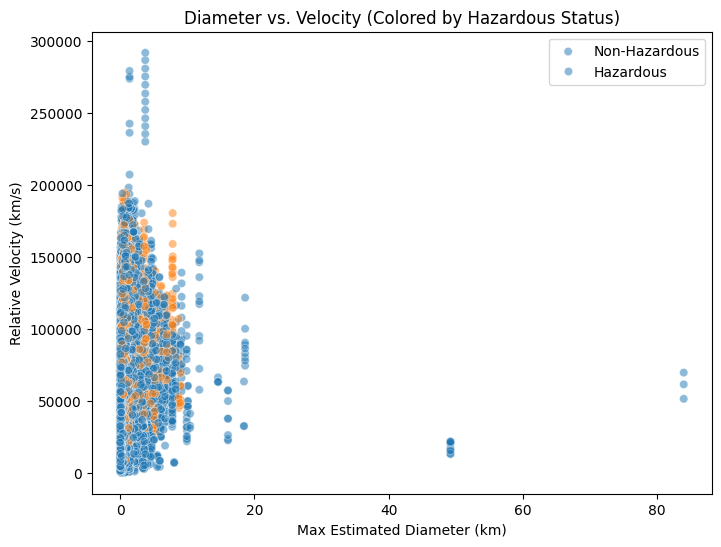

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="estimated_diameter_max", y="relative_velocity", hue="is_hazardous", alpha=0.5)
plt.xlabel("Max Estimated Diameter (km)")
plt.ylabel("Relative Velocity (km/s)")
plt.title("Diameter vs. Velocity (Colored by Hazardous Status)")
plt.legend(["Non-Hazardous", "Hazardous"])
plt.show()


<ipython-input-15-ea63e8fbc053>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_hazardous", data=data, palette="coolwarm")


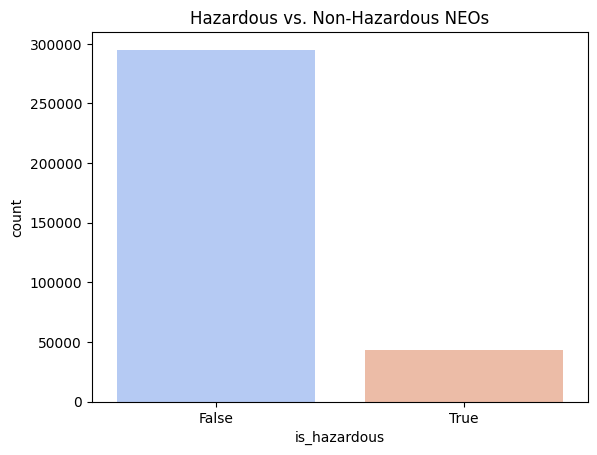

In [15]:
#Hazardous vs. Non-Hazardous NEOs
sns.countplot(x="is_hazardous", data=data, palette="coolwarm")
plt.title("Hazardous vs. Non-Hazardous NEOs")
plt.show()


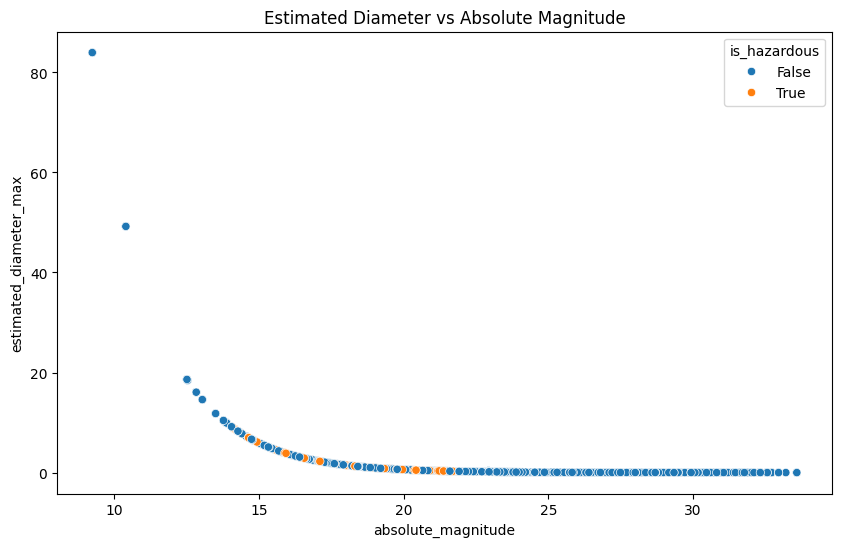

In [67]:
# Scatter plot of Estimated Diameter vs Absolute Magnitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='absolute_magnitude', y='estimated_diameter_max', hue='is_hazardous', data=data)
plt.title('Estimated Diameter vs Absolute Magnitude')
plt.show()

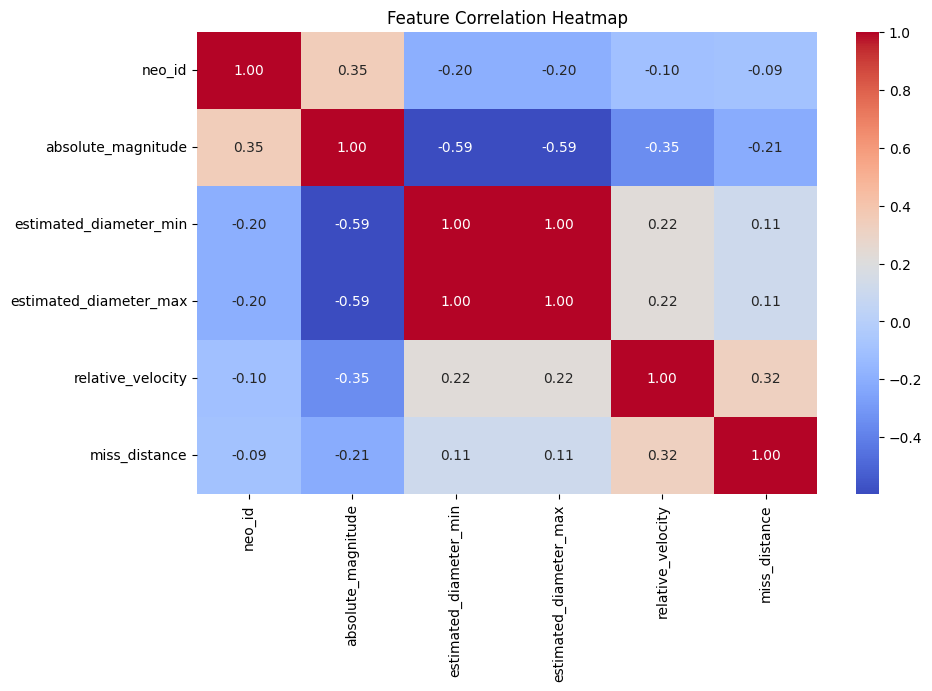

In [16]:
#Correlation Between Numerical Features
plt.figure(figsize=(10, 6))
sns.heatmap(data.select_dtypes('number').corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


#LogisticRegression

In [36]:
log_model = LogisticRegression()

In [38]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [41]:
y_pred_log = log_model.predict(X_test)
accuracy_score_log = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy_score_log)
precision_score_log = precision_score(y_test, y_pred_log)
print("Precision:", precision_score_log)
recall_score_log = recall_score(y_test, y_pred_log)
print("Recall:", recall_score_log)
f1_score_log = f1_score(y_test, y_pred_log)
print("F1 Score:", f1_score_log)

Accuracy: 0.796293078482479
Precision: 0.7548669050456893
Recall: 0.8787143022314718
F1 Score: 0.812095955548432


# LGBMClassifier

In [42]:
lgm_model = LGBMClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
lgm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34513, number of negative: 34546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 69059, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499761 -> initscore=-0.000956
[LightGBM] [Info] Start training from score -0.000956


LGBMClassifier(random_state=42)

In [43]:
y_pred_lgm = lgm_model.predict(X_test)
accuracy_score_lgm = accuracy_score(y_test, y_pred_lgm)
print("Accuracy:", accuracy_score_lgm)
precision_score_lgm = precision_score(y_test, y_pred_lgm)
print("Precision:", precision_score_lgm)
recall_score_lgm = recall_score(y_test, y_pred_lgm)
print("Recall:", recall_score_lgm)
f1_score_lgm = f1_score(y_test, y_pred_lgm)
print("F1 Score:", f1_score_lgm)

Accuracy: 0.845815233130611
Precision: 0.7716178205244533
Recall: 0.9832350560758469
F1 Score: 0.8646670055922725


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# RandomForestClassifier

In [44]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
y_pred_rfc = rfc_model.predict(X_test)
accuracy_score_rfc = accuracy_score(y_test, y_pred_rfc)
print("Accuracy:", accuracy_score_rfc)
precision_score_rfc = precision_score(y_test, y_pred_rfc)
print("Precision:", precision_score_rfc)
recall_score_rfc = recall_score(y_test, y_pred_rfc)
print("Recall:", recall_score_rfc)
f1_score_rfc = f1_score(y_test, y_pred_rfc)
print("F1 Score:", f1_score_rfc)

Accuracy: 0.8707211120764553
Precision: 0.8312854930304595
Recall: 0.9308590588507342
F1 Score: 0.8782589724010036


# NN

In [55]:
# Build Improved Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),


    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),

    Dense(1, activation='sigmoid')
])

# Compile Model with Learning Rate Scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train with More Epochs & Adaptive Learning Rate
callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.7812 - loss: 0.4529
Epoch 2/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8191 - loss: 0.3877
Epoch 3/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8214 - loss: 0.3849
Epoch 4/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8226 - loss: 0.3825
Epoch 5/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8242 - loss: 0.3797
Epoch 6/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8291 - loss: 0.3744
Epoch 7/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8327 - loss: 0.3699
Epoch 8/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8321 - loss: 0.3714
Epoch 9/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8303 - loss: 0.3706
Epoch 10/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8309 - loss: 0.3707
Epoch 11/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8303 - loss: 0.3704
Epoch 12/15
2159/2159 ━

In [56]:
y_pred_nn = model.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)
accuracy_score_nn = accuracy_score(y_test, y_pred_nn)
print("Accuracy:", accuracy_score_nn)
precision_score_nn = precision_score(y_test, y_pred_nn)
print("Precision:", precision_score_nn)
recall_score_nn = recall_score(y_test, y_pred_nn)
print("Recall:", recall_score_nn)
f1_score_nn = f1_score(y_test, y_pred_nn)
print("F1 Score:", f1_score_nn)

540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8377063423110339
Precision: 0.759474571758232
Recall: 0.9893629321308822
F1 Score: 0.8593090982124925


# Conclusion
# **best model is Random forest**

# Dash board

In [59]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

dash_app = dash.Dash(__name__)

dash_app.layout = html.Div([
    html.H1("NEO Prediction Dashboard"),

    dcc.Graph(id='model-comparison-graph'),

    dcc.Dropdown(
        id='model-dropdown',
        options=[
            {'label': 'Logistic Regression', 'value': 'log'},
            {'label': 'LGBM Classifier', 'value': 'lgm'},
            {'label': 'Random Forest Classifier', 'value': 'rfc'},
            {'label': 'Neural Network', 'value': 'nn'}
        ],
        value='log',  # Default model
        clearable=False
    )
])

In [60]:
@dash_app.callback(
    Output('model-comparison-graph', 'figure'),
    Input('model-dropdown', 'value')
)
def update_graph(selected_model):
    if selected_model == 'log':
        accuracy = accuracy_score_log
        precision = precision_score_log
        recall = recall_score_log
        f1 = f1_score_log
    elif selected_model == 'lgm':
        accuracy = accuracy_score_lgm
        precision = precision_score_lgm
        recall = recall_score_lgm
        f1 = f1_score_lgm
    elif selected_model == 'rfc':
        accuracy = accuracy_score_rfc
        precision = precision_score_rfc
        recall = recall_score_rfc
        f1 = f1_score_rfc
    elif selected_model == 'nn':
        accuracy = accuracy_score_nn
        precision = precision_score_nn
        recall = recall_score_nn
        f1 = f1_score_nn

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=['Model'], y=[accuracy]),
        go.Bar(name='Precision', x=['Model'], y=[precision]),
        go.Bar(name='Recall', x=['Model'], y=[recall]),
        go.Bar(name='F1 Score', x=['Model'], y=[f1])
    ])

    fig.update_layout(barmode='group', title_text=f'{selected_model.upper()} Model Performance')
    return fig

In [61]:
if __name__ == '__main__':
    dash_app.run_server(mode='inline')

<IPython.core.display.Javascript object>